In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from glob import glob
import IPython.display as ipd
import tensorflow as tf
from PIL import Image

In [14]:
df = pd.read_csv("kaggle/bird-song-data-set/bird_songs_metadata.csv")
df.head(3)

df["name"].value_counts()

name
Song Sparrow            1256
Northern Mockingbird    1182
Northern Cardinal       1074
American Robin          1017
Bewick's Wren            893
Name: count, dtype: int64

<BarContainer object of 5 artists>

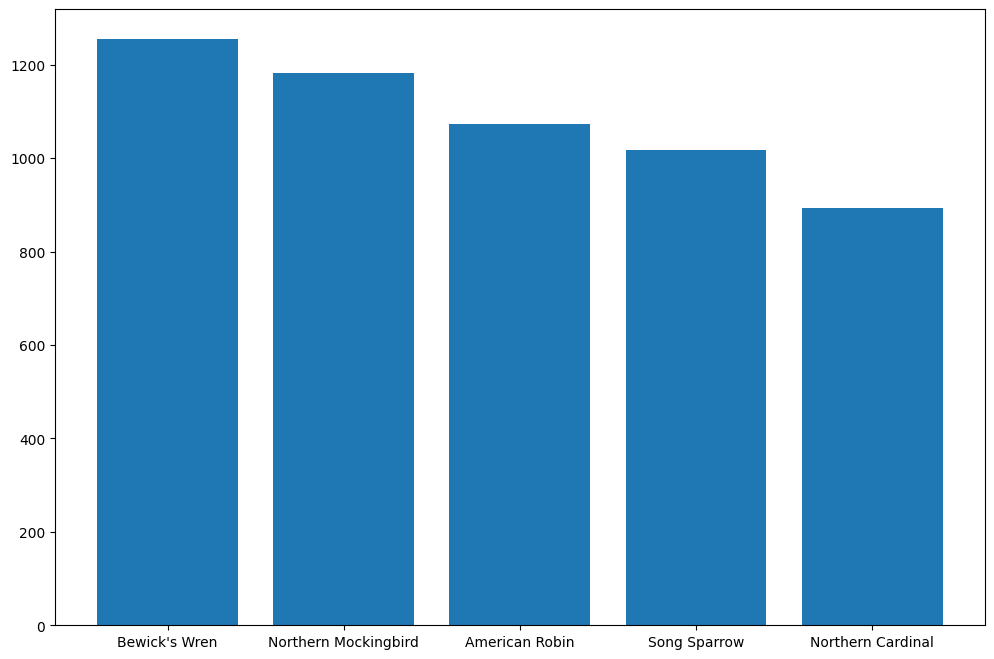

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(df["name"].unique(), df["name"].value_counts())

In [18]:
path_to_wav = "kaggle/bird-song-data-set/wavfiles/"
datafiles = glob(path_to_wav + "*")

In [20]:
def create_mel_spectogram(audio_file, name):
    y, sr = librosa.load(path_to_wav + audio_file)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr) 
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    fig, ax = plt.subplots(figsize=(15, 5))

    ax.set_title("Mel Spec")
    plt.suptitle(name)
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='log', ax=ax)
    return ipd.Audio(path_to_wav + audio_file, rate=sr)

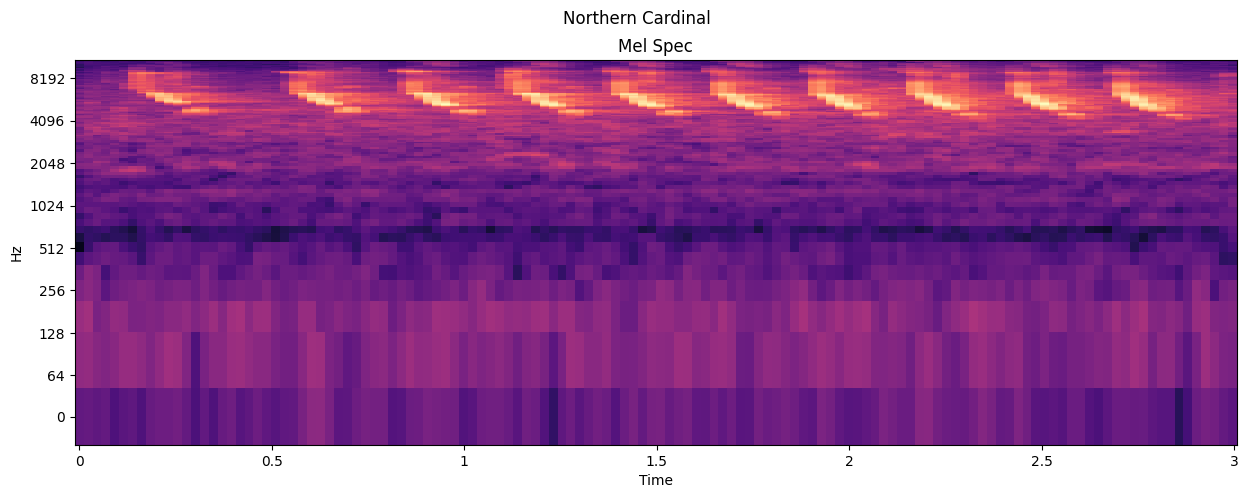

In [24]:
i = np.random.randint(0, df.shape[0])
create_mel_spectogram(df.loc[i, "filename"], df.loc[i, "name"])

In [26]:
def process_audio(audio_file):
    y, sr = librosa.load(audio_file, duration=10)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr) 
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec

In [27]:
df_train = pd.DataFrame({"name":df.loc[:, "name"], "audiopath": path_to_wav + df.loc[:, "filename"]})
df_train["mel_spec"] = df_train["audiopath"].apply(process_audio)
df_train["class"] = df_train["name"].factorize()[0]

In [28]:
from sklearn.utils import shuffle

df_train = shuffle(df_train)
df_train.shape

(5422, 4)

In [29]:
(train_x, train_y) = df_train["mel_spec"][:5000].values, df_train["class"][:5000].values
(test_x, test_y) = df_train["mel_spec"][5000:].values, df_train["class"][5000:].values

In [30]:
from keras.utils import to_categorical

test_y = to_categorical(test_y, num_classes=5)
train_y = to_categorical(train_y, num_classes=5)

In [31]:
train_x = np.stack(train_x[:])
test_x = np.stack(test_x[:])

train_x = tf.keras.utils.normalize(train_x)
test_x = tf.keras.utils.normalize(test_x)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [32]:
train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Reshape, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

In [37]:
def create_model():
    model = Sequential(name="model")

    model.add(InputLayer(input_shape=(128, 130)))
    model.add(Reshape((128, 130, 1)))
    model.add(Conv2D(64, (8, 8), input_shape=(128, 130), activation='relu', padding='same'))
    model.add(Conv2D(64, (6, 6), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5))
    model.add(Activation('softmax'))

    return model

In [38]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 128, 130, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 130, 64)      4160      
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 130, 64)      147520    
                                                                 
 dropout_4 (Dropout)         (None, 128, 130, 64)      0         
                                                                 
 batch_normalization_4 (Bat  (None, 128, 130, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 65, 64)        0         
 g2D)                                                        

In [39]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)

from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.01), metrics=['accuracy']) ##lr=0.01 decay=1e-6)

In [40]:
model.fit(train_dataset, epochs=200, validation_data=test_dataset, callbacks=[checkpoint_cb])

Epoch 1/200


625/625 [==============================] - ETA: 0s - loss: 6.7340 - accuracy: 0.4412

C:\Users\Rahul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 853s 1s/step - loss: 6.7340 - accuracy: 0.4412 - val_loss: 4.6947 - val_accuracy: 0.2915
Epoch 2/200
625/625 [==============================] - 908s 1s/step - loss: 3.0970 - accuracy: 0.5078 - val_loss: 2.6821 - val_accuracy: 0.5379
Epoch 3/200
625/625 [==============================] - 866s 1s/step - loss: 2.3291 - accuracy: 0.5552 - val_loss: 2.4308 - val_accuracy: 0.4455
Epoch 4/200
625/625 [==============================] - 866s 1s/step - loss: 1.9189 - accuracy: 0.5692 - val_loss: 2.2821 - val_accuracy: 0.4455
Epoch 5/200
625/625 [==============================] - 854s 1s/step - loss: 1.7809 - accuracy: 0.5970 - val_loss: 2.1593 - val_accuracy: 0.5711
Epoch 6/200
625/625 [==============================] - 855s 1s/step - loss: 1.7281 - accuracy: 0.6212 - val_loss: 1.9803 - val_accuracy: 0.5711
Epoch 7/200
625/625 [==============================] - 858s 1s/step - loss: 1.9410 - accuracy: 0.6434 - val_loss: 1.9688 - val_accuracy: 0.6564
Epoc

KeyboardInterrupt: 